<a href="https://colab.research.google.com/github/aaronw99/ta-time/blob/master/MLProject_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import gc
import matplotlib as mpl
from google.colab import drive
import seaborn as sns
import numpy as np

In [4]:
drive.mount("/content/gdrive")

!unzip "/content/gdrive/My Drive/ML Project/yelp_academic_dataset_review.json.zip"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/My Drive/ML Project/yelp_academic_dataset_review.json.zip
replace yelp_academic_dataset_review.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [5]:
# This method is reproduced from the utils_yelp library provided by at https://www.kaggle.com/kubak182/utils-yelp
def loadJSON(path, data_dict,size=-1):
    """
        Function that loads data. Since the reviews is not JSON itself, but each row it is, i need to read it line by line.
        :param path: path to file
        :param data_dict: columns:list
        :param size: how many lines to load
        :rtype size: int
        :rtype path: str
        :rtype data_dict: dict
        :return: data with values read.

    """

    # check input
    if len(data_dict) == 0:
        raise RuntimeError("No columns")

    else:
        cnt = -1
        # data are to big to load in normal way, seoncondly, it seems no correct json format.
        with open(path, 'rb') as f:
            from json import loads
            if size !=-1:
                cnt = 0
            for line in f:
                cnt+=1
                line = loads(line)
                # not happy about nested loops, but for now it will do.
                for key in data_dict.keys():
                    # not using get method, since i need to raise error if key not exists
                    data_dict[key].append(line[key])
                del line
                if cnt > 0 and cnt == size  :
                    break
            # with contectx should do work but just in case
            f.close()
    return data_dict

filename = "yelp_academic_dataset_review.json"
df = pd.DataFrame(loadJSON(filename,{'stars': [], 'text':[], 'useful': [], 'funny':[], 'cool': [], 'date':[]},size=5000000))
gc.collect()

271

In [7]:
stars = df['stars']
text = df['text']
useful = df['useful']
funny = df['funny']
cool = df['cool']
import string 

#**Baseline Neural Network**

In [34]:
from sklearn.model_selection import train_test_split             
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences

# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 

nn_reviews = text[0:100000]
nn_stars = stars[0:100000]

import nltk
from nltk.tokenize import word_tokenize  
from nltk import WordNetLemmatizer
print('NLTK Version: %s' % (nltk.__version__))
nltk.download('stopwords')
nltk.download('punkt')
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')

lemma = WordNetLemmatizer()

for i in range(len(nn_reviews)):
  nn_reviews[i] = nn_reviews[i].translate(str.maketrans('', '', string.punctuation))
  nn_reviews[i] = nn_reviews[i].lower()

  words = nn_reviews[i].split()
  words = [word for word in words if not word in nltk_stopwords]
  words = [lemma.lemmatize(word, pos = "v") for word in words]
  words = [lemma.lemmatize(word, pos = "n") for word in words]
  nn_reviews[i] = " ".join(words)

NLTK Version: 3.2.5
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
# The maximum number of words to be used. (most frequent)
# This limits the data set to the top 50000 words.
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# tokenize all of the reviews 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789', lower=True)

# NOTE: possibly get rid of numbers as well 
tokenizer.fit_on_texts(nn_reviews) # creates the vocabulary index based on word frequency
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Truncate and pad the input sequences so that they are all in the same length for modeling
X = tokenizer.texts_to_sequences(nn_reviews) # Transforms each text in texts to a sequence of integers.
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# convert categorical variable into dummy/indicator variables
Y = pd.get_dummies(nn_stars).values
print('Shape of label tensor:', Y.shape)

Found 92849 unique tokens.
Shape of data tensor: (100000, 250)
Shape of label tensor: (100000, 5)


In [36]:
# train test split the data 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(90000, 250) (90000, 5)
(10000, 250) (10000, 5)


In [37]:
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import metrics
import tensorflow as tf
from tensorflow import keras


model = Sequential()

# first layer is the embedded layer that uses 100 length vectors to represent each word.
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

# SpatialDropout1D performs variational dropout in NLP models 
model.add(SpatialDropout1D(0.6))

# next layer is the LSTM layer with 100 memory units
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# output layer creates 5 output values for each star value 
model.add(Dense(5, activation='softmax')) # for final layer of network, 'softmax' activation function returns probability distribution over target classes in multi-class classification problem

# Activation function --> softmax for multi-class classification
# opt = keras.optimizers.Adam(learning_rate=0.005) # attempting to manually change LR in adam 
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy', tf.keras.metrics.Precision()])

# reduce learning rate once metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.005)

epochs = 10 # number of times entire dataset gets passed through network, more epochs = more # of times weights changed in NN, goes from underfitting to overfitting
batch_size = 64 # number of training samples in one batch, where one batch is one portion of your training data
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001), reduce_lr])

Epoch 1/10
1125/1125 [==============================] - 695s 615ms/step - loss: 1.1300 - accuracy: 0.5193 - precision_5: 0.6635 - val_loss: 0.8660 - val_accuracy: 0.6328 - val_precision_5: 0.7332
Epoch 2/10
1125/1125 [==============================] - 692s 615ms/step - loss: 0.8428 - accuracy: 0.6391 - precision_5: 0.7169 - val_loss: 0.8640 - val_accuracy: 0.6362 - val_precision_5: 0.6904
Epoch 3/10
1125/1125 [==============================] - 695s 618ms/step - loss: 0.7793 - accuracy: 0.6716 - precision_5: 0.7336 - val_loss: 0.8464 - val_accuracy: 0.6397 - val_precision_5: 0.7015
Epoch 4/10
1125/1125 [==============================] - 697s 619ms/step - loss: 0.7392 - accuracy: 0.6924 - precision_5: 0.7432 - val_loss: 0.8481 - val_accuracy: 0.6419 - val_precision_5: 0.6917
Epoch 5/10
1125/1125 [==============================] - 696s 619ms/step - loss: 0.6914 - accuracy: 0.7134 - precision_5: 0.7590 - val_loss: 0.8838 - val_accuracy: 0.6384 - val_precision_5: 0.6788
Epoch 6/10
1125/1125

**Visualizing Accuracy and Precision Across SpatialDropout1D Values**

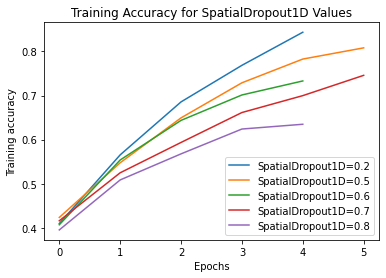

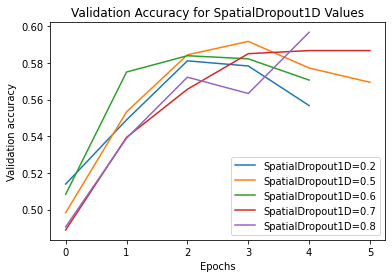

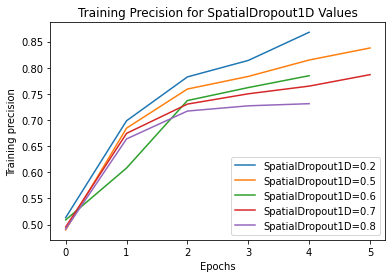

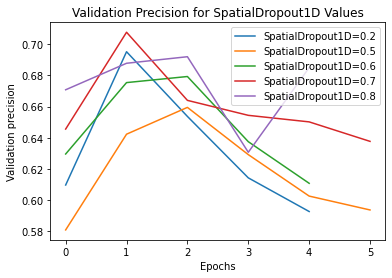

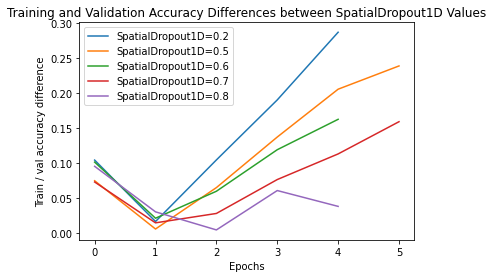

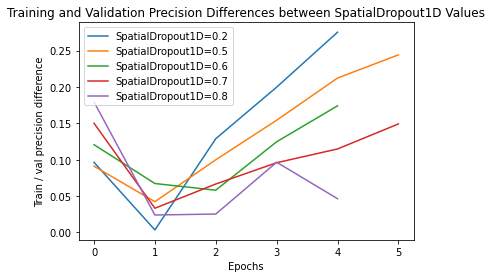

In [ ]:
# spatial dropout 1D 0.2
acc_02 = np.array([0.4097, 0.5654, 0.6855, 0.7684, 0.8434])
prec_02 = np.array([0.5134, 0.6986, 0.7825, 0.814, 0.8679])
valacc_02 = np.array([0.5139, 0.5489, 0.5811, 0.5783, 0.5567])
valprec_02 = np.array([0.6097, 0.6952, 0.6537, 0.6143, 0.5927])
acc_diff02 = abs(acc_02 - valacc_02)
prec_diff02 = abs(prec_02 - valprec_02)

# spatial dropout 1D 0.5
acc_05 = np.array([0.4236, 0.5475, 0.6493, 0.7288, 0.7826, 0.808])
prec_05 = np.array([0.4899, 0.6845, 0.7593, 0.7834, 0.8148, 0.8378])
valacc_05 = np.array([0.4983, 0.5533, 0.5844, 0.5917, 0.5772, 0.5694])
valprec_05 = np.array([0.5809, 0.6423, 0.6595, 0.6292, 0.6026, 0.5937])
acc_diff05 = abs(acc_05 - valacc_05)
prec_diff05 = abs(prec_05 - valprec_05)

# spatial dropout 1D 0.6
acc_06 = np.array([0.407, 0.5538, 0.6436, 0.7012, 0.7330])
prec_06 = np.array([0.509, 0.6082, 0.7373, 0.7621, 0.7848])
valacc_06 = np.array([0.5083, 0.5750, 0.5839, 0.5822, 0.5706])
valprec_06 = np.array([0.6296, 0.6754, 0.6793, 0.6375, 0.6108])
acc_diff06 = abs(acc_06 - valacc_06)
prec_diff06 = abs(prec_06 - valprec_06)

# spatial dropout 1D 0.7
acc_07 = np.array([0.416, 0.5248, 0.5936, 0.6614, 0.6997, 0.7457])
prec_07 = np.array([0.4955, 0.6745, 0.7305, 0.7502, 0.7649, 0.7868])
valacc_07 = np.array([0.4889, 0.5394, 0.5656, 0.585, 0.5867, 0.5867])
valprec_07 = np.array([0.6456, 0.7077, 0.664, 0.6544, 0.6502, 0.6377])
acc_diff07 = abs(acc_07 - valacc_07)
prec_diff07 = abs(prec_07 - valprec_07)

# spatial dropout 1D 0.8
acc_08 = np.array([0.3953, 0.5086, 0.5677, 0.6240, 0.6348])
prec_08 = np.array([0.4915, 0.6639, 0.7172, 0.7272, 0.7313])
valacc_08 = np.array([0.4906, 0.5389, 0.5722, 0.5633, 0.5967])
valprec_08 = np.array([0.6708, 0.6878, 0.6920, 0.6307, 0.6850])
acc_diff08 = abs(acc_08- valacc_08)
prec_diff08 = abs(prec_08 - valprec_08)

# training accuracy graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_02, label='SpatialDropout1D=0.2')
ax.plot(acc_05, label='SpatialDropout1D=0.5')
ax.plot(acc_06, label='SpatialDropout1D=0.6')
ax.plot(acc_07, label='SpatialDropout1D=0.7')
ax.plot(acc_08, label='SpatialDropout1D=0.8')
ax.title.set_text("Training Accuracy for SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Training accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# validation accuracy graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(valacc_02, label='SpatialDropout1D=0.2')
ax.plot(valacc_05, label='SpatialDropout1D=0.5')
ax.plot(valacc_06, label='SpatialDropout1D=0.6')
ax.plot(valacc_07, label='SpatialDropout1D=0.7')
ax.plot(valacc_08, label='SpatialDropout1D=0.8')
ax.title.set_text("Validation Accuracy for SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Validation accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# training precision graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(prec_02, label='SpatialDropout1D=0.2')
ax.plot(prec_05, label='SpatialDropout1D=0.5')
ax.plot(prec_06, label='SpatialDropout1D=0.6')
ax.plot(prec_07, label='SpatialDropout1D=0.7')
ax.plot(prec_08, label='SpatialDropout1D=0.8')
ax.title.set_text("Training Precision for SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Training precision')
mpl.pyplot.legend()
mpl.pyplot.show()

# validation precision graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(valprec_02, label='SpatialDropout1D=0.2')
ax.plot(valprec_05, label='SpatialDropout1D=0.5')
ax.plot(valprec_06, label='SpatialDropout1D=0.6')
ax.plot(valprec_07, label='SpatialDropout1D=0.7')
ax.plot(valprec_08, label='SpatialDropout1D=0.8')
ax.title.set_text("Validation Precision for SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Validation precision')
mpl.pyplot.legend()
mpl.pyplot.show()

# training and validation accuracy differences graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_diff02, label='SpatialDropout1D=0.2')
ax.plot(acc_diff05, label='SpatialDropout1D=0.5')
ax.plot(acc_diff06, label='SpatialDropout1D=0.6')
ax.plot(acc_diff07, label='SpatialDropout1D=0.7')
ax.plot(acc_diff08, label='SpatialDropout1D=0.8')
ax.title.set_text("Training and Validation Accuracy Differences between SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Train / val accuracy difference')
mpl.pyplot.legend()
mpl.pyplot.show()

# training and validation precision differences graphs
fig, ax = mpl.pyplot.subplots()
ax.plot(prec_diff02, label='SpatialDropout1D=0.2')
ax.plot(prec_diff05, label='SpatialDropout1D=0.5')
ax.plot(prec_diff06, label='SpatialDropout1D=0.6')
ax.plot(prec_diff07, label='SpatialDropout1D=0.7')
ax.plot(prec_diff08, label='SpatialDropout1D=0.8')
ax.title.set_text("Training and Validation Precision Differences between SpatialDropout1D Values")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Train / val precision difference')
mpl.pyplot.legend()
mpl.pyplot.show()

***Visualizing Accuracy and Loss for Manually Changing LR***


*   patience = 2



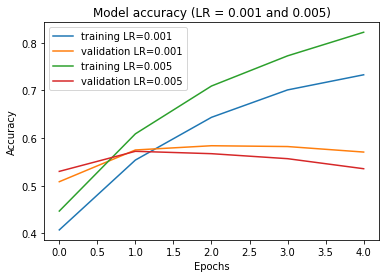

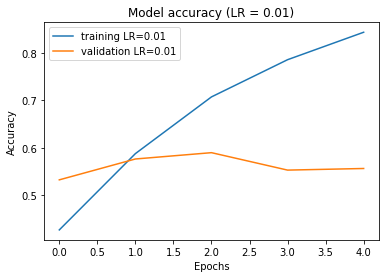

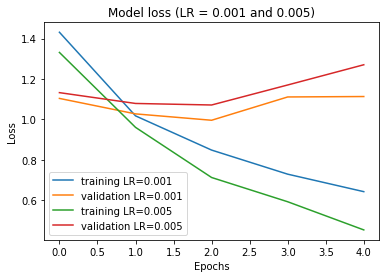

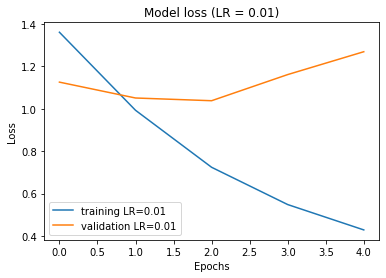

In [26]:
# LR set to 0.001 
loss_LR001 = [1.4317, 1.0176, 0.8481, 0.7288, 0.6422]
acc_LR001 = [0.4070, 0.5538, 0.6436, 0.7012, 0.7330]
val_accLR001 = [0.5083, 0.5750, 0.5839, 0.5822, 0.5706]
val_lossLR001 = [1.1040, 1.0274, 0.9958, 1.1112, 1.1133]

# LR set to 0.005 
loss_LR005 = [1.3317, 0.9607, 0.7123, 0.5922, 0.4527]
acc_LR005 = [0.4466, 0.6089, 0.7094, 0.7728, 0.8224]
val_lossLR005 = [1.1326, 1.0790, 1.0714, 1.1705, 1.2707]
val_accLR005 = [0.5300, 0.5722, 0.5672, 0.5567, 0.5356]

# LR set to 0.01 
acc_LR01 = [0.4274, 0.5880, 0.7074, 0.7857, 0.8435]
val_accLR01 = [0.5328, 0.5767, 0.5900, 0.5533, 0.5567]
loss_LR01 = [1.3598, 0.9924, 0.7240, 0.5485, 0.4291]
val_lossLR01= [1.1249, 1.0502, 1.0374, 1.1605, 1.2681]

# accuracy plots 0.001 and 0.005
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_LR001, label='training LR=0.001')
ax.plot(val_accLR001, label='validation LR=0.001')
ax.plot(acc_LR005, label='training LR=0.005')
ax.plot(val_accLR005, label='validation LR=0.005')
ax.title.set_text("Model accuracy (LR = 0.001 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# accuracy plots 0.01
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_LR01, label='training LR=0.01')
ax.plot(val_accLR01, label='validation LR=0.01')
ax.title.set_text("Model accuracy (LR = 0.01)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# loss plots 0.001 and 0.005
fig, ax = mpl.pyplot.subplots()
ax.plot(loss_LR001, label='training LR=0.001')
ax.plot(val_lossLR001, label='validation LR=0.001')
ax.plot(loss_LR005, label='training LR=0.005')
ax.plot(val_lossLR005, label='validation LR=0.005')
ax.title.set_text("Model loss (LR = 0.001 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

# loss plots 0.01
fig, ax = mpl.pyplot.subplots()
ax.plot(loss_LR01, label='training LR=0.01')
ax.plot(val_lossLR01, label='validation LR=0.01')
ax.title.set_text("Model loss (LR = 0.01)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

**Visualizing Accuracy and Loss using ReduceLROnPlateau**


*   patience = 4



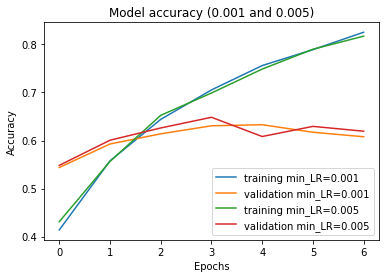

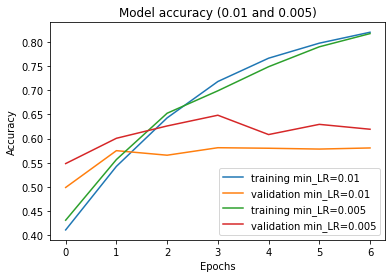

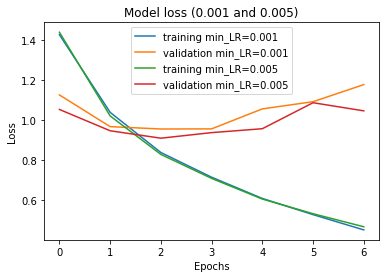

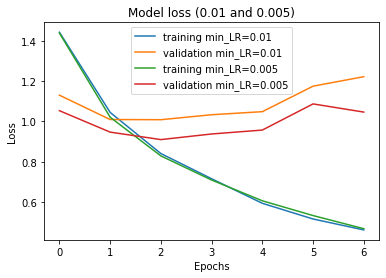

In [33]:
# ReduceLROnPlateau: min LR set to 0.001 
acc_LR = [0.4140, 0.5577, 0.6440, 0.7052, 0.7559, 0.7890, 0.8252]
val_accLR = [0.5439, 0.5928, 0.6139, 0.6306, 0.6328, 0.6172, 0.6078]
loss_LR = [1.4276, 1.0391, 0.8382, 0.7147, 0.6083, 0.5274, 0.4509]
val_lossLR = [1.1263, 0.9676, 0.9558, 0.9564, 1.0564, 1.0924, 1.1780]

# ReduceLROnPlateau: min LR set to 0.005 
acc_LR2 = [0.4312, 0.5566, 0.6524, 0.6988, 0.7486, 0.7898, 0.8171]
val_accLR2 = [0.5483, 0.6006, 0.6261, 0.6483, 0.6083, 0.6294, 0.6193]
loss_LR2 = [1.4399, 1.0211, 0.8287, 0.7087, 0.6054, 0.5319, 0.4666]
val_lossLR2= [1.0536, 0.947, 0.9098, 0.9377, 0.9572, 1.0873, 1.0466]

# ReduceLROnPlateau: min LR set to 0.01
loss_LR3 = [1.4438, 1.0451, 0.8404, 0.7151, 0.5929, 0.5148, 0.4605] 
acc_LR3 = [0.4111, 0.5425, 0.6428, 0.7180, 0.7662, 0.7973, 0.8199]
val_lossLR3 = [1.1307, 1.0097, 1.0087, 1.0335, 1.0487, 1.1755, 1.2227]
val_accLR3 = [0.4989, 0.5750, 0.5656, 0.5811, 0.5800, 0.5783, 0.5806]

# accuracy plots (0.001 and 0.005)
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_LR, label='training min_LR=0.001')
ax.plot(val_accLR, label='validation min_LR=0.001')
ax.plot(acc_LR2, label='training min_LR=0.005')
ax.plot(val_accLR2, label='validation min_LR=0.005')
ax.title.set_text("Model accuracy (0.001 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# accuracy plots (0.005 and 0.01)
fig, ax = mpl.pyplot.subplots()
ax.plot(acc_LR3, label='training min_LR=0.01')
ax.plot(val_accLR3, label='validation min_LR=0.01')
ax.plot(acc_LR2, label='training min_LR=0.005')
ax.plot(val_accLR2, label='validation min_LR=0.005')
ax.title.set_text("Model accuracy (0.01 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Accuracy')
mpl.pyplot.legend()
mpl.pyplot.show()

# loss plots 0.001 and 0.005
fig, ax = mpl.pyplot.subplots()
ax.plot(loss_LR, label='training min_LR=0.001')
ax.plot(val_lossLR, label='validation min_LR=0.001')
ax.plot(loss_LR2, label='training min_LR=0.005')
ax.plot(val_lossLR2, label='validation min_LR=0.005')
ax.title.set_text("Model loss (0.001 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

# loss plots 0.01 and 0.005
fig, ax = mpl.pyplot.subplots()
ax.plot(loss_LR3, label='training min_LR=0.01')
ax.plot(val_lossLR3, label='validation min_LR=0.01')
ax.plot(loss_LR2, label='training min_LR=0.005')
ax.plot(val_lossLR2, label='validation min_LR=0.005')
ax.title.set_text("Model loss (0.01 and 0.005)")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

***Visualizations increased to 100k reviews***

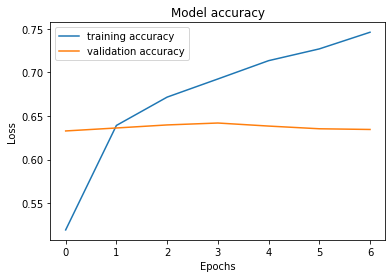

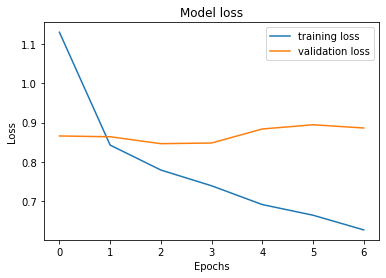

In [38]:
loss = [1.1300, 0.8428, 0.7793, 0.7392, 0.6914, 0.6643, 0.6269]
acc = [0.5193, 0.6391, 0.6716, 0.6924, 0.7134, 0.7269, 0.7460]
val_loss = [0.8660, 0.8640, 0.8464, 0.8481, 0.8838, 0.8945, 0.8863]
val_acc = [ 0.6328, 0.6362, 0.6397, 0.6419, 0.6384, 0.6353, 0.6345]

# accuracy plotting 
fig, ax = mpl.pyplot.subplots()
ax.plot(acc, label='training accuracy')
ax.plot(val_acc, label='validation accuracy')
ax.title.set_text("Model accuracy")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

# loss plotting
fig, ax = mpl.pyplot.subplots()
ax.plot(loss, label='training loss')
ax.plot(val_loss, label='validation loss')
ax.title.set_text("Model loss")
mpl.pyplot.xlabel('Epochs')
mpl.pyplot.ylabel('Loss')
mpl.pyplot.legend()
mpl.pyplot.show()

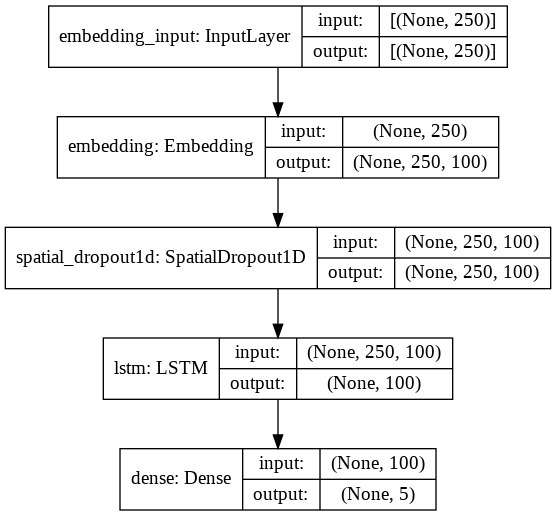

In [ ]:
# visualize model 
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# improve learning rate, which is part of adam and also dropout rate

# **Comparing Model Accuracies with Keras Preprocessing Library**

In [ ]:
nn_reviews = text[0:10000]
nn_stars = stars[0:10000]

# The maximum number of words to be used. (most frequent)
# This limits the data set to the top 50000 words.
MAX_NB_WORDS = 50000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 250

# tokenize all of the reviews 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# NOTE: possibly get rid of numbers as well 
tokenizer.fit_on_texts(nn_reviews) # creates the vocabulary index based on word frequency
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

keras_reviews = tokenizer.texts_to_matrix(nn_reviews, mode='tfidf')
keras_stars = nn_stars

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

model = ComplementNB()
model.fit(keras_reviews, keras_stars)
print(model.score(keras_reviews, keras_stars))

p1 = model.predict(keras_reviews)

# compute accuracy for each rating
accuracy(1, p1, keras_stars)
accuracy(2, p1, keras_stars)
accuracy(3, p1, keras_stars)
accuracy(4, p1, keras_stars)
accuracy(5, p1, keras_stars)